# Notebook to play around with data and models 

In [85]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

import statsmodels.api as sm

In [86]:
import numpy as np
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression

def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

In [3]:
df = pd.read_pickle('Data/conclave_participants_features.pkl')

In [4]:
df_living = pd.read_pickle('Data/living_participants.pkl')

In [59]:
def fit_model_cv(data, model, split_col, scale_data=False):
    
    # Copy data and exclude retired cardinals.
    df = data.copy()
    
    for conclave in df[split_col].unique():
        print(conclave)
        # Get data for one conclave.
        conclave_df = df.loc[df[split_col]==conclave].copy()
        
        # Select elected pope record and separate it from train set.
        elected_pope = conclave_df.loc[df['Elected']==1] 
        conclave_df.drop(elected_pope.index, inplace=True)
        
        # Split folds.
        spliter = ShuffleSplit(n_splits=10, test_size=0.7)
        scaler = StandardScaler()
        
        for train_index, test_index in spliter.split(conclave_df):
#             print("TRAIN:", train_index, "TEST:", test_index)
            
            train_df = conclave_df.iloc[train_index, :]
            train_df = train_df.append(elected_pope)
                        
            X = train_df.drop(columns=['Elected', split_col, 'Name']).values
            y = train_df['Elected'].values

            if scale_data == True:
                X_scaled = scaler.fit_transform(X)
                model.fit(X_scaled, y)
            else:
                model.fit(X, y)
        
    return model

### Prepare test data, as if conclave were to take place in July 2020

In [48]:
from datetime import datetime, timedelta

datetime(2020, 7, 1)

datetime.datetime(2020, 7, 1, 0, 0)

In [68]:
assumed_conclave_date = datetime(2020, 7, 1)
df_living['Age_at_conclave'] = ((assumed_conclave_date - df_living['Born']) / timedelta(days=365)).astype(int)
df_living['Card_seniority'] = ((assumed_conclave_date - df_living['Consistory']) / timedelta(days=30)).astype(int)

df_living = df_living.loc[df_living['Age_at_conclave'] < 80]

df_living.head(1)

,Name,Born,Consistory,CB,CD,CP,Italian,Emeritus,Archbishop,Other_curia,Prefect,Age_at_conclave,Card_seniority,prediction_logreg
0,Leonardo Sandri,1943-11-18,2007-11-24,1,0,0,0,0,0,0,1,76,153,0.101309


In [69]:
cols_to_take = df.drop(columns=['Elected', 'Date', 'Name']).columns

df_test = df_living[cols_to_take]
df_test.head(1)

,Italian,Emeritus,Age_at_conclave,Card_seniority,Archbishop,Other_curia,Prefect,CB,CD,CP
0,0,0,76,153,0,0,1,1,0,0


# Prediction

a) Logistic Regression

In [71]:
df.loc[df['Elected']==1]

,Name,Date,Elected,Italian,Emeritus,Age_at_conclave,Card_seniority,Archbishop,Other_curia,Prefect,CB,CD,CP
21,Achille Ratti,1922-02-02,1,1,0,64,5,1,0,0,0,0,1
71,Eugenio Pacelli,1939-03-01,1,1,0,63,118,0,1,0,0,0,1
143,Angelo Giuseppe Roncalli,1958-10-25,1,1,0,76,50,1,0,0,0,0,1
217,Giovanni Battista Montini,1963-06-19,1,1,0,65,54,1,0,0,0,0,1
242,Albino Luciani,1978-08-25,1,1,0,65,69,1,0,0,0,0,1
402,Karol Wojtyła,1978-10-14,1,0,0,58,141,1,0,0,0,0,1
469,Joseph Ratzinger,2005-04-19,1,0,0,78,327,0,0,1,1,0,0
650,Jorge Mario Bergoglio,2013-03-12,1,0,0,76,156,1,0,0,0,0,1


In [72]:
logreg = LogisticRegression(warm_start=True, class_weight='balanced')
logreg_fitted = fit_model_cv(df, model=logreg, split_col='Date', scale_data=True)

df_test_scaled = StandardScaler().fit_transform(df_test)

y_pred_logreg = logreg_fitted.predict_proba(df_test_scaled)[:, 1]

df_living['prediction_logreg'] = y_pred_logreg
df_living[['Name', 'prediction_logreg']].sort_values(by=['prediction_logreg'], ascending=False).head(30)

1922-02-02T00:00:00.000000000
1939-03-01T00:00:00.000000000
1958-10-25T00:00:00.000000000
1963-06-19T00:00:00.000000000
1978-08-25T00:00:00.000000000
1978-10-14T00:00:00.000000000
2005-04-19T00:00:00.000000000
2013-03-12T00:00:00.000000000


,Name,prediction_logreg
12,Wilfrid Fox Napier OFM,0.888037
7,Vinko Puljić,0.845250
13,Óscar Andrés Rodríguez Maradiaga SDB,0.841480
9,Christoph Schönborn OP,0.828475
25,Seán Patrick O'Malley OFMCap,0.721881
34,John Njue,0.687356
30,Oswald Gracias,0.642677
41,Dominik Duka OP,0.635736
24,Antonio Cañizares Llovera,0.634656
78,Maurice Piat CSSp,0.618999


In [53]:
logreg_fitted

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=True)

In [57]:
pd.DataFrame({'vars': df.drop(columns=['Elected', 'Date', 'Name']).columns,
              'coefs': logreg_fitted.coef_[0],
              'Beta': np.exp(logreg_fitted.coef_[0])})

,vars,coefs,Beta
0,Italian,-0.758145,0.468535
1,Emeritus,-1.053574,0.348689
2,Age_at_conclave,1.253489,3.502543
3,Card_seniority,0.650960,1.917381
4,Archbishop,0.362666,1.437156
5,Other_curia,-0.308623,0.734458
6,Prefect,-0.172060,0.841928
7,CB,-0.154147,0.857146
8,CD,-0.152919,0.858199
9,CP,0.206021,1.228779


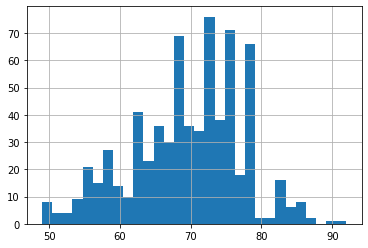

In [58]:
df['Age_at_conclave'].hist(bins=30)

In [55]:
print(logreg_fitted.intercept_)

[-1.98122615]


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=True)


### Po usunieciu zmiennych zakodowanych

In [79]:
df2 = df.drop(columns=['Archbishop', 'CP']).copy()

In [80]:
logreg = LogisticRegression(warm_start=True, class_weight='balanced')
logreg_fitted = fit_model_cv(df2, model=logreg, split_col='Date', scale_data=True)

df_test_scaled = StandardScaler().fit_transform(df_test.drop(columns=['Archbishop', 'CP']))

y_pred_logreg = logreg_fitted.predict_proba(df_test_scaled)[:, 1]

df_living['prediction_logreg'] = y_pred_logreg
df_living[['Name', 'prediction_logreg']].sort_values(by=['prediction_logreg'], ascending=False).head(30)

1922-02-02T00:00:00.000000000
1939-03-01T00:00:00.000000000
1958-10-25T00:00:00.000000000
1963-06-19T00:00:00.000000000
1978-08-25T00:00:00.000000000
1978-10-14T00:00:00.000000000
2005-04-19T00:00:00.000000000
2013-03-12T00:00:00.000000000


,Name,prediction_logreg
12,Wilfrid Fox Napier OFM,0.867558
78,Maurice Piat CSSp,0.791809
13,Óscar Andrés Rodríguez Maradiaga SDB,0.781042
67,Ricardo Blázquez Pérez,0.748710
41,Dominik Duka OP,0.708957
25,Seán Patrick O'Malley OFMCap,0.688126
9,Christoph Schönborn OP,0.683365
34,John Njue,0.675780
86,Gregorio Rosa Chávez,0.669362
7,Vinko Puljić,0.640238


In [84]:
df_living.sort_values(by=['prediction_logreg'], ascending=False).head(10)

,Name,Born,Consistory,CB,CD,CP,Italian,Emeritus,Archbishop,Other_curia,Prefect,Age_at_conclave,Card_seniority,prediction_logreg
12,Wilfrid Fox Napier OFM,1941-03-08,2001-02-21,0,0,1,0,0,1,0,0,79,235,0.867558
78,Maurice Piat CSSp,1941-07-17,2016-11-19,0,0,1,0,0,1,0,0,79,44,0.791809
13,Óscar Andrés Rodríguez Maradiaga SDB,1942-12-29,2001-02-21,0,0,1,0,0,1,0,0,77,235,0.781042
67,Ricardo Blázquez Pérez,1942-04-13,2015-02-14,0,0,1,0,0,1,0,0,78,65,0.748710
41,Dominik Duka OP,1943-04-26,2012-02-18,0,0,1,0,0,1,0,0,77,101,0.708957
25,Seán Patrick O'Malley OFMCap,1944-06-29,2006-03-24,0,0,1,0,0,1,0,0,76,173,0.688126
9,Christoph Schönborn OP,1945-01-22,1998-02-21,0,0,1,0,0,1,0,0,75,272,0.683365
34,John Njue,1944-01-01,2007-11-24,0,0,1,0,0,1,0,0,76,153,0.675780
86,Gregorio Rosa Chávez,1942-09-03,2017-06-28,0,0,1,0,0,1,0,0,77,36,0.669362
7,Vinko Puljić,1945-09-08,1994-11-26,0,0,1,0,0,1,0,0,74,311,0.640238


In [91]:
pd.DataFrame({'vars': df2.drop(columns=['Elected', 'Date', 'Name']).columns,
              'coefs': logreg_fitted.coef_[0],
              'Beta': np.exp(logreg_fitted.coef_[0]),
              'pvalue': logit_pvalue(logreg_fitted, df_test_scaled)[1:]})

,vars,coefs,Beta,pvalue
0,Italian,-0.405564,0.666601,0.195469
1,Emeritus,-0.954493,0.385007,0.002960
2,Age_at_conclave,1.697373,5.459589,0.000556
3,Card_seniority,0.194801,1.215069,0.448767
4,Other_curia,-0.437317,0.645766,0.321192
5,Prefect,-0.375558,0.686906,0.415841
6,CB,-0.115270,0.891125,0.750307
7,CD,-0.423629,0.654667,0.461316


b) Gradient Boosting Classifier

In [92]:
GBC = GradientBoostingClassifier(warm_start=True)
GBC_fitted = fit_model_cv(df2, model=GBC, split_col='Date')

y_pred_GBC = GBC_fitted.predict_proba(df_test.drop(columns=['Archbishop', 'CP']))[:, 1]

df_living['prediction_GBC'] = y_pred_GBC
df_living[['Name', 'prediction_GBC']].sort_values(by=['prediction_GBC'], ascending=False).head()

1922-02-02T00:00:00.000000000
1939-03-01T00:00:00.000000000
1958-10-25T00:00:00.000000000
1963-06-19T00:00:00.000000000
1978-08-25T00:00:00.000000000
1978-10-14T00:00:00.000000000
2005-04-19T00:00:00.000000000
2013-03-12T00:00:00.000000000


,Name,prediction_GBC
0,Leonardo Sandri,0.000077
91,Désiré Tsarahazana,0.000077
89,António Augusto dos Santos Marto,0.000077
88,Joseph Coutts,0.000077
87,Angelo De Donatis,0.000077


In [96]:
pd.DataFrame({'vars': df2.drop(columns=['Elected', 'Date', 'Name']).columns,
              'feature_importances': GBC_fitted.feature_importances_})

,vars,feature_importances
0,Italian,0.0
1,Emeritus,0.0
2,Age_at_conclave,0.0
3,Card_seniority,1.0
4,Other_curia,0.0
5,Prefect,0.0
6,CB,0.0
7,CD,0.0
